# Cluster Analysis

Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group are more similar to each other than to those in other groups.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette('gnuplot2', n_colors=10)
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
all_95 = pd.read_csv("./data/all_95.csv", header = [0,1], index_col=0)
all_100 = pd.read_csv("./data/all_100.csv", header = [0,1], index_col=0)
all_150 = pd.read_csv("./data/all_150.csv", header = [0,1], index_col=0)
df = pd.read_csv("./data/agg_all.csv", index_col=0)
df

,Subj,Total,A,B,C,D,Study,Bad,Good,StudyNo,Payload
0,95_Subj_1,12.105263,0.126316,0.094737,0.031579,0.747368,Fridberg,0.221053,0.778947,1,1
1,95_Subj_2,-7.105263,0.252632,0.273684,0.126316,0.347368,Fridberg,0.526316,0.473684,1,1
2,95_Subj_3,-7.894737,0.126316,0.368421,0.105263,0.400000,Fridberg,0.494737,0.505263,1,1
3,95_Subj_4,-5.526316,0.115789,0.357895,0.126316,0.400000,Fridberg,0.473684,0.526316,1,1
4,95_Subj_5,1.052632,0.105263,0.252632,0.157895,0.484211,Fridberg,0.357895,0.642105,1,1
...,...,...,...,...,...,...,...,...,...,...,...
612,150_Subj_94,2.000000,0.160000,0.460000,0.086667,0.293333,Wetzels,0.620000,0.380000,8,2
613,150_Subj_95,14.333333,0.033333,0.206667,0.306667,0.453333,Wetzels,0.240000,0.760000,8,2
614,150_Subj_96,9.666667,0.120000,0.126667,0.246667,0.506667,Wetzels,0.246667,0.753333,8,2
615,150_Subj_97,8.000000,0.166667,0.200000,0.293333,0.340000,Wetzels,0.366667,0.633333,8,2


##  1. The Optimal Number of Clusters

There are two methods to find the optimal number of clusters for a dataset, the Elbow Method and the Silhouette Method. 

### 1.1 The Elbow Method

This is the most common method for determining the optimal number of clusters. To do this you must calculate the Within-Cluster-Sum of Squared Errors (WSS) for different values of *k*, and choose the *k* for which WSS first starts to diminish. In a plot of WSS-versus-k, this is visible as an elbow.

In [3]:
def elbow_score(x):
    distortions = []
    K = range(1,11)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(x)
        distortions.append(kmeanModel.inertia_)
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

### 1.2 The Silhouette Method


This is a method to  find the optimal number of clusters *k*. The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). A high value is desirable. This is the formula:

$$
s(i) = \frac{b(i) - a(i)}{max(a(i), b(i))}
$$

>**_NOTE:_** *s(i)* is defined to be equal to zero if *i* is the only point in the cluster. This is to prevent the number of clusters from increasing significantly with many single-point clusters.

*a(i)* is the measure of the similarity of the point *i* to its own cluster. 

$$
a(i) = \frac{1}{\lvert C_{i}\rvert - 1} \sum_{j{\in}C_{i}, i{\neq}j} d(i,j)
$$

Similarly, *b(i)* is the measure of dissimilarity of *i* from points in other clusters.

$$
b(i) = \min_{i{\neq}j} \frac{1}{\lvert C_{j}\rvert} \sum_{j{\in}C_{j}} d(i,j)
$$

Where *d(i,j)* is the euclidean distance between the two points.


In [4]:
def sil_value(x):
    sil = []
    kmax = 10

    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in range(3, kmax+1):
      kmeans = KMeans(n_clusters = k).fit(x)
      labels = kmeans.labels_
      sil.append(silhouette_score(x, labels, metric = 'euclidean'))
    
    return sil

# https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

## 2. Clustering the Data

I chose to perform clustering on the total amount won or lost compared to the amount the participants chose the deck 'C'. I thought this would be interesting because C was a "good" deck but had frequent losses. The losses also depended on the payload of the study. I wanted to see if the clusters had any relationship to the payload.

I also wanted to cluster the data comparing the total amount won or lost to the amount of times the participants chose a "good" deck. This would be interesting to see if there was anything in particular that defined each of these clusters.

### 2.1 Performing Clustering on Deck C

I began by making a dataframe with just 'Total' and 'C' columns.

In [5]:
c = df.iloc[:,[1,4]] 
c

,Total,C
0,12.105263,0.031579
1,-7.105263,0.126316
2,-7.894737,0.105263
3,-5.526316,0.126316
4,1.052632,0.157895
...,...,...
612,2.000000,0.086667
613,14.333333,0.306667
614,9.666667,0.246667
615,8.000000,0.293333


I then used the elbow method and the silhouette method to find the optimal number of clusters.

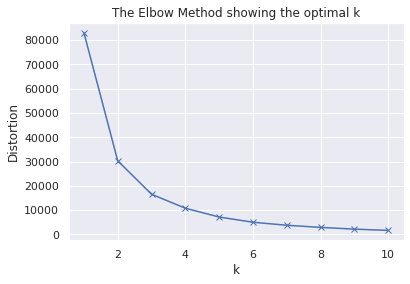

In [6]:
elbow_score(c)

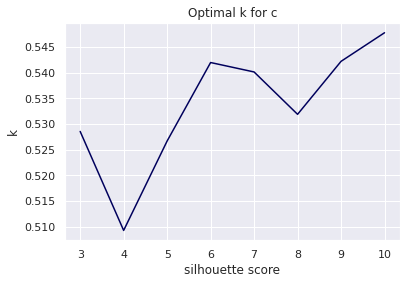

In [7]:
c_sil = sil_value(c)

plt.plot([3,4,5,6,7,8,9,10], c_sil)
plt.title('Optimal k for c')
plt.xlabel('silhouette score')
plt.ylabel('k')
plt.show()

It was not completely clear from the elbow method whick value I should use for *k*. It looked to be between 3 and 7. In the silhouette method the peak was at 10 but there was also a slightly lower peak at 7. For this reason I chose 7 as my *k* and made 7 clusters.

I used `sklearn.cluster.KMeans` to create the clusters and fit them to the data.

In [8]:
c_kmeans = KMeans(7)
c_kmeans.fit(c)

KMeans(n_clusters=7)

I then find the identified clusters in c.

In [9]:
c_identified_clusters = c_kmeans.fit_predict(c)
c_identified_clusters

array([4, 3, 3, 3, 0, 4, 3, 0, 3, 4, 3, 3, 0, 3, 0, 1, 3, 3, 4, 6, 6, 0,
       6, 4, 3, 0, 0, 0, 3, 0, 0, 6, 6, 3, 0, 3, 0, 6, 0, 4, 4, 3, 0, 3,
       0, 4, 3, 0, 3, 4, 3, 0, 6, 1, 4, 0, 0, 0, 6, 6, 3, 3, 3, 0, 1, 0,
       6, 1, 4, 0, 0, 3, 3, 3, 6, 0, 2, 3, 4, 6, 0, 0, 0, 4, 4, 6, 2, 0,
       4, 3, 0, 6, 0, 3, 4, 0, 3, 0, 4, 6, 3, 4, 1, 3, 6, 4, 0, 4, 4, 3,
       0, 3, 3, 0, 0, 4, 0, 6, 4, 0, 0, 4, 3, 4, 4, 0, 1, 0, 0, 3, 0, 6,
       1, 3, 4, 0, 4, 4, 6, 0, 0, 3, 4, 4, 0, 3, 4, 3, 3, 4, 4, 4, 0, 6,
       6, 0, 2, 0, 3, 3, 6, 4, 3, 4, 3, 4, 3, 6, 3, 0, 0, 0, 1, 0, 6, 0,
       0, 1, 3, 6, 3, 4, 4, 0, 3, 6, 1, 0, 3, 5, 0, 4, 4, 3, 0, 1, 0, 0,
       0, 0, 0, 3, 4, 4, 3, 0, 0, 0, 2, 0, 4, 3, 3, 3, 4, 3, 4, 3, 4, 3,
       2, 4, 4, 6, 2, 0, 0, 6, 2, 4, 3, 0, 3, 0, 4, 0, 0, 6, 0, 2, 6, 6,
       3, 0, 4, 3, 6, 0, 4, 3, 3, 4, 4, 6, 4, 0, 3, 3, 6, 0, 4, 3, 4, 1,
       0, 6, 6, 6, 4, 0, 0, 1, 4, 4, 0, 6, 4, 3, 0, 6, 3, 6, 3, 2, 1, 3,
       4, 4, 6, 0, 0, 0, 3, 0, 4, 6, 3, 6, 6, 4, 6,

This is a graph of the data with the different clusters shown in different colours.

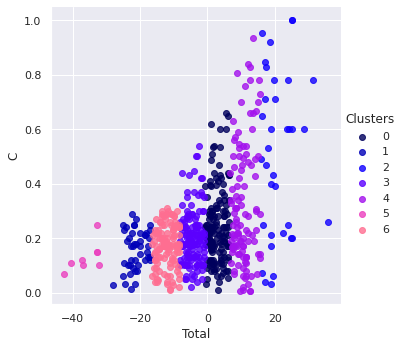

In [10]:
c_data_with_clusters = df.copy()
c_data_with_clusters['Clusters'] = c_identified_clusters 

sns.lmplot(data=c_data_with_clusters, x='Total', y='C', hue='Clusters', 
            fit_reg=False, legend=True)

Then, for a comparison, I plotted the data using colour to differentiate payload.

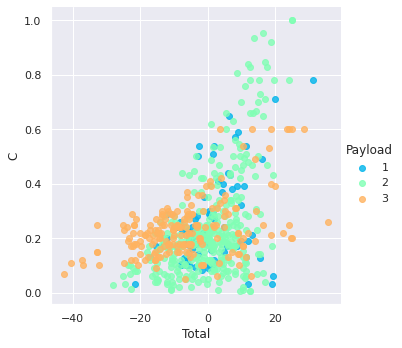

In [11]:
sns.lmplot(data=c_data_with_clusters, x='Total', y='C', hue='Payload', 
            fit_reg=False, legend=True, palette='rainbow')


As you can see the datapoints in cluster 6 all chose c less and had the highest loss in the study. All of these data points were in payload 3. This makes sense because these people obviously chose C less because they were getting frequent losses from it and those losses were growing as they went. Most of the people who chose C the most were in payload 2 which is where the losses in C were constant.

### 2.2 Performing Clustering on "Good" Decks

Now I would like to cluster the data based on the "good" card decks to see if there is any insight to be gleamed from it.

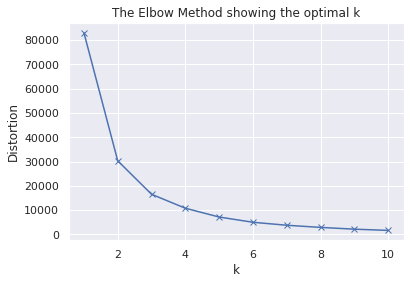

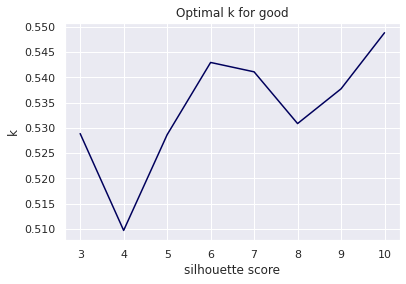

In [12]:
good = df.iloc[:,[1,7]]

elbow_score(good)

good_sil = sil_value(good)
good_k = good_sil.index(max(good_sil)) + 2

plt.plot([3,4,5,6,7,8,9,10], good_sil)
plt.title('Optimal k for good')
plt.xlabel('silhouette score')
plt.ylabel('k')
plt.show()

There is no clear *k* from the elbow plot, and the peak at 10 is a fair bit higher than any other peak in the silhouette plot. Therefore, I chose to make 10 clusters this time.

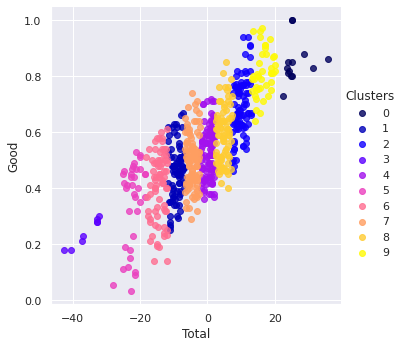

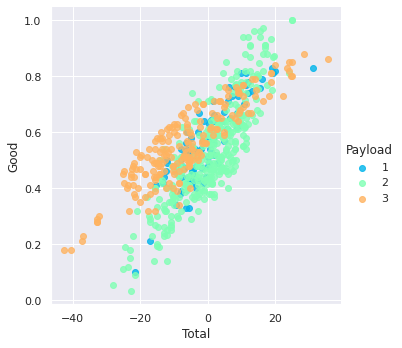

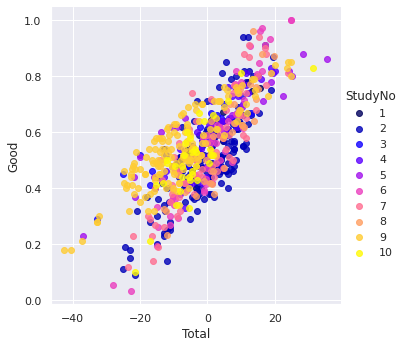

In [13]:
good_kmeans = KMeans(10)
good_kmeans.fit(good)
good_identified_clusters = good_kmeans.fit_predict(good)

good_data_with_clusters = df.copy()
good_data_with_clusters['Clusters'] = good_identified_clusters 
sns.lmplot(data=good_data_with_clusters, x='Total', y='Good', hue='Clusters', 
                   fit_reg=False, legend=True)


sns.lmplot(data=good_data_with_clusters, x='Total', y='Good', hue='Payload', 
                   fit_reg=False, legend=True, palette='rainbow')


sns.lmplot(data=good_data_with_clusters, x='Total', y='Good', hue='StudyNo', 
                   fit_reg=False, legend=True)


As you can see from the two graphs, there is obviously a strong correlation between picking "good" decks and winning more money. There does not seem to be any correlation between payload and "good" decks though. Maia et al. frequently asked the participants about their knowledge of the decks at regular intervals during the task. This is study number 4 and is shown in yellow on the graph. Nothing major stands out about this study except there were less people who chose the "bad" decks. It is hard to see because the datapoints for study 4 are all in the centre of the graph but there are a lot less of their datapoints under 0.4 than the other studies. 

### 2.3 Further Analysis of "Good" Decks

I would now like to look more closely at clusters 7 and 9 because they are the most extreme on each side. It is said that after about 50 choices most people begin to see the patterns ang go for the "good" decks more consistently. I want to see if the people in cluster 9 seemed to figure out the pattern and the people in cluster 7 did not.

I began by getting the number of the good cluster (9) and the bad cluster (7). This is just in case the cluster numbers change at some point.

In [14]:
good_cluster = good_data_with_clusters[good_data_with_clusters['Total'] == max(good_data_with_clusters['Total'])]['Clusters'].iloc(0)[0]
bad_cluster = good_data_with_clusters[good_data_with_clusters['Total'] == min(good_data_with_clusters['Total'])]['Clusters'].iloc(0)[0]

I then found the subjects of the cluster so that I could find out whether they belonged to 95, 100, or 150. I then looked at the choices they made after the first 50 rounds and did some analysis on that. 

In [15]:
good_subj_1 = list(good_data_with_clusters[good_data_with_clusters['Clusters'] == bad_cluster]['Subj'])
good_subj_1

good_lst = []
for i in good_subj_1:
    n, idx = i.split('_', 1)
    if n == '100':
        good_lst.append(list(all_100[all_100.index == idx].values[0])[101::2])
    elif n == '150':
        good_lst.append(list(all_150[all_150.index == idx].values[0])[101::2])
    elif n == '95':
        good_lst.append(list(all_95[all_95.index == idx].values[0])[101::2])

good_d = {'a' : 0, 'b' : 0, 'c' : 0, 'd' : 0}
good_l, no_bad = [], []
for i in good_lst:
    c = Counter(i)
    good_d['a'] += c[1]
    good_d['b'] += c[2]
    good_d['c'] += c[3]
    good_d['d'] += c[4]
    if c[1] + c[2] != 0:
        good_l.append((c[3] + c[4]) / (c[1] + c[2]))
    else:
        no_bad.append(c)
print(good_d)
print(len([x for x in good_l if x < .5]))
print(len(good_l))
print(no_bad)
print(np.mean(good_l))

{'a': 67, 'b': 239, 'c': 46, 'd': 48}
6
8
[]
0.3690945336047337


This cluster chose 'B' the most and 6 out of 8 people were twice as likely to choose "bad" decks over "good" decks. This shows that the people in this cluster probably did not see the pattern and got distracted by the infrequent losses in Deck B.

The mean of the ratios between good and bad is 0.369, which shows that the participants in the cluster were far less likely to choose good decks. If the mean was 1 it would mean that the participants chose fairly evenly between the "good" and "bad" decks.

In [16]:
good_subj_2 = list(good_data_with_clusters[good_data_with_clusters['Clusters'] == good_cluster]['Subj'])
good_subj_2

good_lst = []
for i in good_subj_2:
    n, idx = i.split('_', 1)
    if n == '100':
        good_lst.append(list(all_100[all_100.index == idx].values[0])[101::2])
    elif n == '150':
        good_lst.append(list(all_150[all_150.index == idx].values[0])[101::2])
    elif n == '95':
        good_lst.append(list(all_95[all_95.index == idx].values[0])[101::2])

good_d = {'a' : 0, 'b' : 0, 'c' : 0, 'd' : 0}
good_l, no_bad = [], []
for i in good_lst:
    c = Counter(i)
    good_d['a'] += c[1]
    good_d['b'] += c[2]
    good_d['c'] += c[3]
    good_d['d'] += c[4]
    if c[1] + c[2] != 0:
        good_l.append((c[3] + c[4]) / (c[1] + c[2]))
    else:
        no_bad.append(c)
        
print(good_d)
print(len([x for x in good_l if x < 1]))
print(len(good_l))
print(no_bad)
print(np.mean(good_l))

{'a': 28, 'b': 18, 'c': 516, 'd': 188}
0
8
[Counter({3: 32, 4: 18}), Counter({3: 37, 4: 13}), Counter({3: 50}), Counter({3: 100}), Counter({3: 100})]
15.049107142857144


In this cluster 'C' was chosen the most despite its frequent losses. None of the participants chose the "bad" decks more frequently than the "good" decks, with some people never choosing the bad decks at all. The mean was 15.049 which is very high. This means that the "bad" were barely chosen in comparison to the "good" decks.

For these reasons I think it is safe to assume that a lot of these participants figured out that the decks C and D contained more rewards than penalties.

## 3. Preserving the Privacy of Each Lab

Next, I wanted to find a way to obtain similar clustering results while preserving the privacy of each lab. 

### 3.1 Using PCA

Principal Component Analysis, or PCA, is a way to reduce the dimensionality of a dataset. It also is able to provide some degree of privacy to the data.

First I dropped the columns that were not numeric and useful.

In [17]:
x = df.drop(columns = ['Subj','Study', 'StudyNo', 'Payload'])

I then performed PCA for two components and added them to a dataframe with the study number and payload.

In [18]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
pca_df = pd.concat([principalDf, df[['StudyNo', 'Payload']]], axis = 1)
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

pca_df

,principal component 1,principal component 2,StudyNo,Payload
0,-13.875027,-0.317474,1,1
1,5.341599,-0.071472,1,1
2,6.130536,-0.110633,1,1
3,3.761851,-0.107813,1,1
4,-2.819895,-0.101765,1,1
...,...,...,...,...
612,-3.757980,-0.293730,8,2
613,-16.102065,-0.053414,8,2
614,-11.436426,-0.046602,8,2
615,-9.766207,-0.009333,8,2


I then got the elbow and silhouette scores and chose 7 as my optimal *k*.

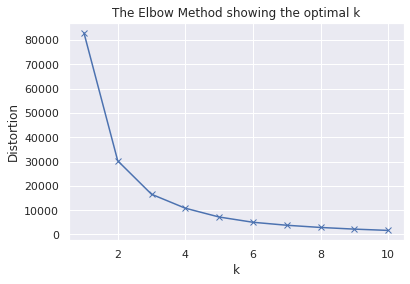

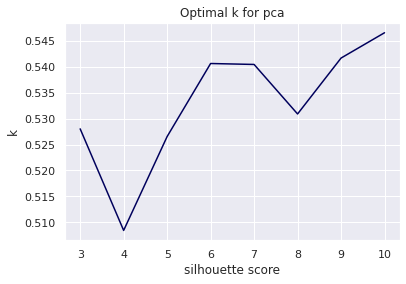

In [19]:
elbow_score(principalDf)

pca_sil = sil_value(principalDf)
pca_k = pca_sil.index(max(pca_sil)) + 2

plt.plot([3,4,5,6,7,8,9,10], pca_sil)
plt.title('Optimal k for pca')
plt.xlabel('silhouette score')
plt.ylabel('k')
plt.show()

I then clustered the data and made graphs showing the clusters, the payload, and the study.

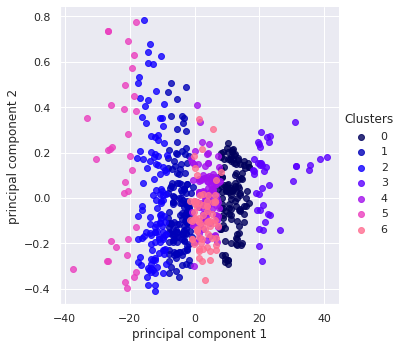

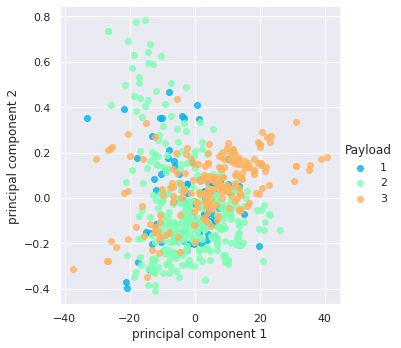

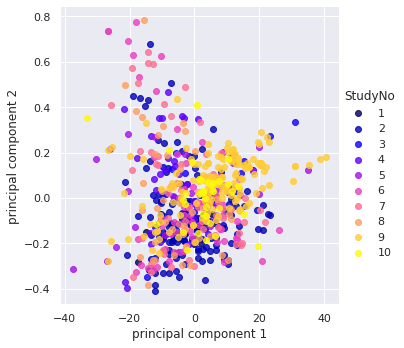

In [20]:
pca_kmeans = KMeans(7)
pca_kmeans.fit(pca_df)
pca_identified_clusters = pca_kmeans.fit_predict(pca_df)

pca_data_with_clusters = pca_df.copy()
pca_data_with_clusters['Clusters'] = pca_identified_clusters 
sns.lmplot(data=pca_data_with_clusters, x='principal component 1', y='principal component 2', hue='Clusters', 
                   fit_reg=False, legend=True)


sns.lmplot(data=pca_data_with_clusters, x='principal component 1', y='principal component 2', hue='Payload', 
                   fit_reg=False, legend=True, palette='rainbow')



sns.lmplot(data=pca_df, x='principal component 1', y='principal component 2', hue='StudyNo', 
                   fit_reg=False, legend=True)

These graphs do not look like the graphs I made before. There is more data in the top left quadrant of the graph. There does not seem to be much correlation between the clusters and the payoff but cluster 4 seems to be made up of majority payload 3 studies. There is no clear connection between these clusters and the studies.

### 3.2 Using Centroids

To do this I decided to perform clustering on each lab's results separately and then cluster their centroids to see if it gave similar results to clustering the data from all of the labs together. For this example I will use the same analysis as before, the 'Total' and the "good" decks.

I looped through the studies and got the silhouette score for each study. I then performed k-means clustering on the data from each study. I added the centroid of each cluste to a dataframe called 'centroids'.

In [21]:
centroids = pd.DataFrame(columns = ['Total', 'Good', 'StudyNo'])
for study in range(1,11):
    
    study_df =  df[df['StudyNo'] == study]
    
    study_good = study_df.iloc[:,[1,7]]
    study_good_sil = sil_value(study_good)
    study_good_k = study_good_sil.index(max(study_good_sil)) + 2

#     plt.plot([3,4,5,6,7,8,9,10], study_good_sil)
#     plt.title('Optimal k for {}'.format(study_df['Study'].iloc(0)[0]))
#     plt.xlabel('silhouette score')
#     plt.ylabel('k')
#     plt.show()

    study_good_kmeans = KMeans(study_good_k)
    study_good_kmeans.fit(study_good)
    study_good_identified_clusters = study_good_kmeans.fit_predict(study_good)

    centers = np.array(study_good_kmeans.cluster_centers_)
    for i in centers:
        centroids = centroids.append({'Total': i[0], 'Good': 1-i[1], 'StudyNo': study}, ignore_index=True)

print(centroids)

        Total      Good  StudyNo
0   -3.710526  0.503158      1.0
1   10.052632  0.705263      1.0
2   11.500000  0.703333      2.0
3   -7.441176  0.462941      2.0
4    0.803571  0.518571      2.0
5  -13.261905  0.326190      2.0
6    4.703704  0.548889      2.0
7  -23.000000  0.173333      2.0
8   17.200000  0.800000      2.0
9   -3.208333  0.465000      2.0
10   7.894737  0.591579      2.0
11  -2.741667  0.558333      3.0
12 -28.975000  0.370000      3.0
13   7.485714  0.685714      3.0
14 -16.375000  0.477500      3.0
15   1.541667  0.581667      4.0
16  12.303571  0.753571      4.0
17  -8.000000  0.426250      4.0
18  25.050000  0.807500      5.0
19  -8.712500  0.587500      5.0
20 -21.150000  0.440000      5.0
21   1.700000  0.592500      5.0
22 -36.950000  0.230000      5.0
23  18.016667  0.766667      5.0
24  35.700000  0.860000      5.0
25   9.366667  0.706667      5.0
26 -14.825000  0.520000      5.0
27  -2.212121  0.456364      6.0
28   9.666667  0.725926      6.0
29 -10.111

Here is a graph of all the centroids. As you can see, it is similar to the graph for all datapoints when plotting 'Total' and 'Good'. It also still captures that some studies had more variation in their 'Total' or in the amount a "good" deck was chosen. For example, the 6th study had people choosing "good" decks all the time and some people never choosing them. In contrast, the people in study 4 mostly chose a "good" deck somewhere between 40% and 80% of the time.

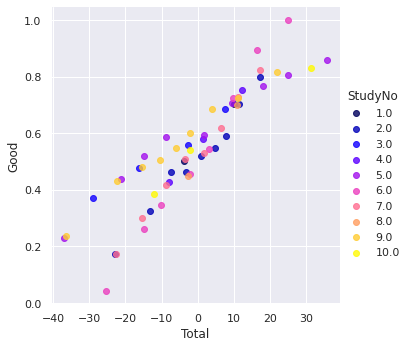

In [22]:
sns.lmplot(data=centroids, x='Total', y='Good', hue='StudyNo', 
           fit_reg=False, legend=True, palette='gnuplot2')

This is where I got the optimal *k* for the centroids data and performed clustering on it. 

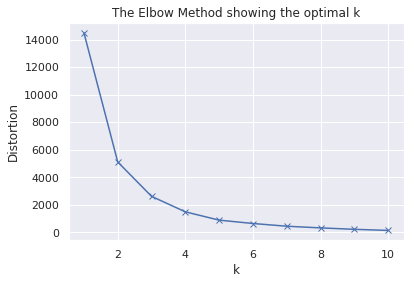

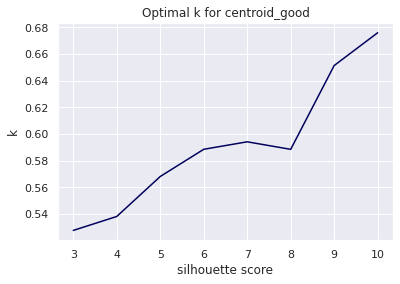

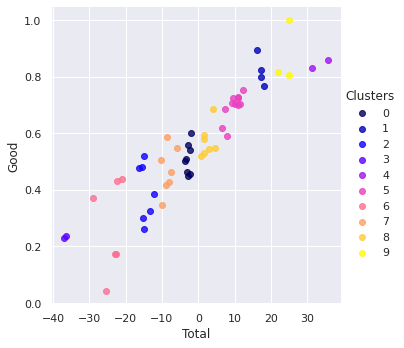

In [23]:
centroid_good = centroids.iloc[:,[0,1]]

elbow_score(centroid_good)

centroid_good_sil = sil_value(centroid_good)
centroid_good_k = centroid_good_sil.index(max(centroid_good_sil)) + 2

plt.plot([3,4,5,6,7,8,9,10], centroid_good_sil)
plt.title('Optimal k for centroid_good')
plt.xlabel('silhouette score')
plt.ylabel('k')
plt.show()

centroid_good_kmeans = KMeans(10)
centroid_good_kmeans.fit(centroid_good)
centroid_good_identified_clusters = centroid_good_kmeans.fit_predict(centroid_good)

centroid_good_data_with_clusters = centroids.copy()
centroid_good_data_with_clusters['Clusters'] = centroid_good_identified_clusters 
sns.lmplot(data=centroid_good_data_with_clusters, x='Total', y='Good', hue='Clusters', 
           fit_reg=False, legend=True)



The clusters show the same as the original clusters that the smaller clusters are on the edge because there are less datapoints there and the ones in the middle are bigger. 

Overall, I would say that this method of preserving privacy is fine if you just want to understand the overall picture of the data and see roughly what way the data would look if it was clustered. However if you want to perform deeper analysis on the data it would not be very useful.

## Conclusion

There are some interesting insights to be learned from this data when it has been clustered. There are relationships between the amount won or lost and the decks chosen, and the payload for the amount deck C was rewarding or penalising may have impacted the way that participants made their decisions. It is also harder to gain insight into the data as a whole when the privacy of each study is preserved.